http://krasserm.github.io/2018/03/19/gaussian-processes/

# Introduction

Gaussian processes are non-parametric methods. Instead of inferring a distribution over the parameters of a parametric function, GP can be sued to infer a distribution over functions directly. It defines a prior over functions and after having observed some function values it can be converted into a posterior over functions.

A Gaussian process is a random process where any point ${x} \in \mathbb{R}^d$ is assigned a random variable $f({x})$ and where the joint distribution of a finite number of these variables $p(f(x_1),...,f(x_N))$ is itself a Gaussian:

$$p(f|X) = \mathcal{N}(f|\mu,K)$$

where $f=(f(x_1),...,f(x_N)$, $\mu=(m(x_1),...,m(x_N))$ and $K_{ij}=k(x_i,x_j)$. $m$ is the mean function and GPs are flexible enough to model the mean arbitrarily well. $k$ is a positive definite kernel function of covariance function. Thus, a Gaussian process is a distirbution over functions whose shape (smoothness,...) is defined by $K$. If points $x_i$ and $x_j$ are considered to be similar by the kernel the function values at these points, $f(x_i)$ and $f(x_j)$ can be expected to be similar too.

Given a training dataset with noise-free function values $f$ at inputs $X$, a GP prior can be converted into a GP posterior $p(f_*|X_*, X, f)$ which can then be used to make predictions $f_*$ at new inputs $X_*$. By definiton of a GP, the joint distribution of observed values $f$ and $f_*$ is again a Gaussian which can be partioned into

$$\begin{eqnarray*}
\begin{pmatrix}f\\
f_*
\end{pmatrix} & \sim & \mathcal{N}\left(\left[\begin{array}{c}
0\\
0
\end{array}\right],\left[\begin{array}{ccc}
K & K_*\\
K^T & K_{**}
\end{array}\right]\right)
\end{eqnarray*}$$

where $K_*=k(X, X_*)$ and $K_{**}=k(X_*,X_*)$. With $N$ training data and $N_*$ new input data $K$ is a $N$x$N$ matrix, K_* a $N$x$N_*$ matrix and $K_{**}$ a $N_*$x$N_{*}$ matrix. Using standard rules for conditioning Gaussians, the predictive distribution is given by

$$\begin{aligned}
p(f_*|X_*, X, f) &= \mathcal{N}(f_*|\mu_*, \Sigma_*) \\
\mu_* &= K_*^TK^{-1}f \\
\Sigma_* &= K_{**} - K_*^TK^{-1}K_*
\end{aligned}$$

If we have a training dataset with noisy function values $y = f + \epsilon$, where noise is $\epsilon \sim \mathcal{N}(0, \sigma^2_yI)$ is independently added to each observation then the predictive distribution is given by

$$\begin{aligned}
p(f_*|X_*, X, f) &= \mathcal{N}(f_*|\mu_*, \Sigma_*) \\
\mu_* &= K_*^TK_y^{-1}f \\
\Sigma_* &= K_{**} - K_*^TK_y^{-1}K_*
\end{aligned}$$

where $K_y = K + \sigma_y^2I$. Although the equation above covers noise in the training data, it is still a distribution over noise-free predictions f_*. To additionally include noise $\epsilon$ into predictions $y_*$ we have to add $\sigma_y^2$ to the diagonal of $\Sigma_*$

$$p(y_*|X_*, X, y) = \mathcal{N}(y_*|\mu_*, \Sigma_* + \sigma_y^2I)$$

# Implementation with NumPy

## Kernel

Here, we will use the squared exponential kernel, also known as Gaussian kernel or RBF kernel:

$$k(x_i, x_i) = \sigma_f^2\exp\big(-\frac{1}{2l^2}(x_i-x_j)^T(x_i - x_j)\big)$$

The length parameter $l$ controls the smoothness of the function and $\sigma_f$ the vertical variation. For simplicity, we use the same length parameter $l$ for all input dimensions (isotropic kernel).

In [1]:
import numpy as np

def kernel(x1, x2, l=1.0, sigma_f=1.0):
    """
    Isotropic squared exponential kernel.
    
    Args:
        x1: Array of m points (m x d)
        x2: Array of n points (n x d)
        
    Returns:
        (m x n) matrix
    """
    sqdist = np.sum(x1**2,1).reshape(-1,1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

In [22]:
# Finite number of points
X = np.arange(-1, 4).reshape(-1, 1)
print(X)
params = [1, 0.1, 10]
# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov1 = kernel(X, X, l=params[0])
print(cov1)

[[-1]
 [ 0]
 [ 1]
 [ 2]
 [ 3]]
[[1.00000000e+00 6.06530660e-01 1.35335283e-01 1.11089965e-02
  3.35462628e-04]
 [6.06530660e-01 1.00000000e+00 6.06530660e-01 1.35335283e-01
  1.11089965e-02]
 [1.35335283e-01 6.06530660e-01 1.00000000e+00 6.06530660e-01
  1.35335283e-01]
 [1.11089965e-02 1.35335283e-01 6.06530660e-01 1.00000000e+00
  6.06530660e-01]
 [3.35462628e-04 1.11089965e-02 1.35335283e-01 6.06530660e-01
  1.00000000e+00]]


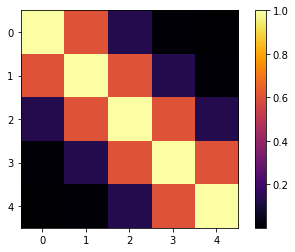

In [23]:
m = plt.imshow(cov1, cmap="inferno", interpolation='none')
plt.colorbar(m);

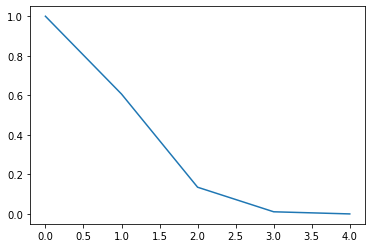

In [29]:
plt.plot(cov1[:,0]);

In the plot above we can see the exponential decay of different points based on their distance, which makes the first line of the covariance function.

## Prior

Let's first define a prior over functions with mean zero and covariance matrix computed with the kernel defined above. To draw random functions from that GP we draw random samples from the corresponding multivariate normal. The following example draws three random samples and plots it together with the zero mean and the 95% confidence interval (computed from the diagonal of the covariance matrix).

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Finite number of points
X = np.arange(-5, 5, 0.2).reshape(-1, 1)

params = [1, 0.1, 10]
# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov1 = kernel(X, X, l=params[0])

# Draw three samples from the prior
samples1 = np.random.multivariate_normal(mu.ravel(), cov1, 3)

In [172]:
cov2 = kernel(X, X, l=params[1])
cov3 = kernel(X, X, l=params[2])

# Draw three samples from the prior
samples2 = np.random.multivariate_normal(mu.ravel(), cov2, 3)
samples3 = np.random.multivariate_normal(mu.ravel(), cov3, 3)

samples1 = np.tile(samples1, (1, 1, 1))
samples2 = np.tile(samples2, (1, 1, 1))
samples3 = np.tile(samples3, (1, 1, 1))
samples =  np.concatenate((samples1, samples2, samples3), axis=0)

In [173]:
cov1 = np.tile(cov1, (1, 1, 1))
cov2 = np.tile(cov2, (1, 1, 1))
cov3 = np.tile(cov3, (1, 1, 1))
cov =  np.concatenate((cov1, cov2, cov3), axis=0)

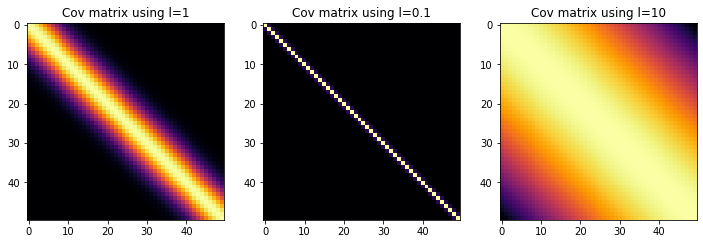

In [174]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

for idx, i in enumerate(params):
    ax[idx].imshow(cov[idx,:,:], cmap="inferno", interpolation='none')
    ax[idx].set_title(f'Cov matrix using l={i}')

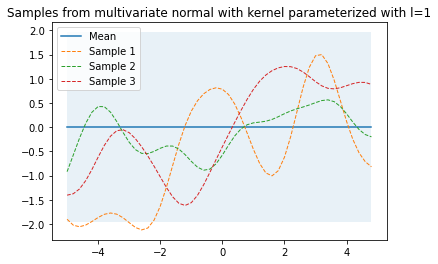

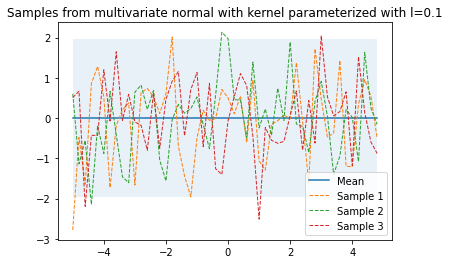

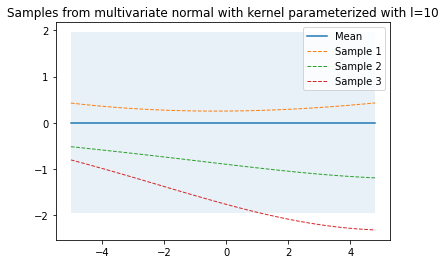

In [175]:
# Plot GP mean, confidence interval and samples 

def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[], title=''):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()
    plt.title(title)
    
# Plot GP mean, confidence interval and samples 
for i in range(3):
    plot_gp(mu, cov[i,:,:], X, samples=samples[i,:,:], title=f'Samples from multivariate normal with kernel parameterized with l={params[i]}')
    plt.show()

# Prediction from noise-free training data

$$\begin{aligned}
p(f_*|X_*, X, f) &= \mathcal{N}(f_*|\mu_*, \Sigma_*) \\
\mu_* &= K_*^TK^{-1}f \\
\Sigma_* &= K_{**} - K_*^TK^{-1}K_*
\end{aligned}$$

In [41]:
from numpy.linalg import inv

def posterior(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    """
    Computes the suffifient statistics of the posterior distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    """
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    # Equation (7)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # Equation (8)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

The following example draws three samples from the posterior and plots them along with the mean, condifence interval and training data. In a noise-free model, variance at the training points is zero and all random functions drawn from the posterior go through the traning points.

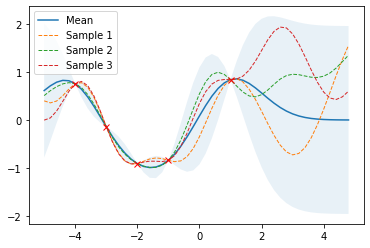

In [159]:
# Noise free training data
X_train = np.array([-4,-3,-2,-1,1]).reshape(-1,1)
Y_train = np.sin(X_train)

# Compute the mean and covariance of the posterior distribution
mu_s, cov_s = posterior(X, X_train, Y_train)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train = Y_train, samples=samples)

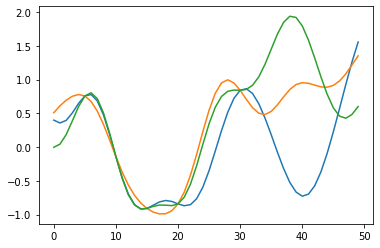

In [160]:
plt.plot(samples.T);

# Prediction from noisy training data

If some noise is included in the model, training points are only approximated and the variance at the training points is non-zero.

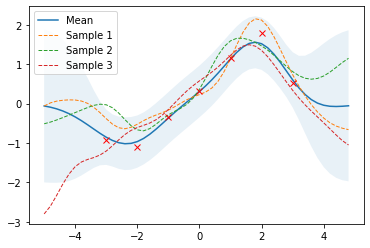

In [161]:
noise = 0.4

# noisy training data
X_train = np.arange(-3, 4, 1).reshape(-1, 1)
Y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

# Compute mean and cov of the posterior distribution
mu_s, cov_s = posterior(X, X_train, Y_train, sigma_y=noise)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

# Effect of kernel parameters and noise parameter

The follwoing example shows the effect of kernel parameters $l$ and $\sigma_f$ as well as the noise parameter $\sigma_y$. Higher $l$ values lead to smooth functions and therefore to coarser approximations of the training data. Lower $l$ values make functions more wiggly with wide confidence intervals between training points. $\sigma_f$ controls the vertical variation of the functions drawn from the GP. This can be seen by the wide confidence intervals outside the training data region in the right figure of the second row. $\sigma_y$ represents the amount of noise in the training data. Higher $\sigma_y$ values make more coarse approximations which avoids overfitting to noisy data.

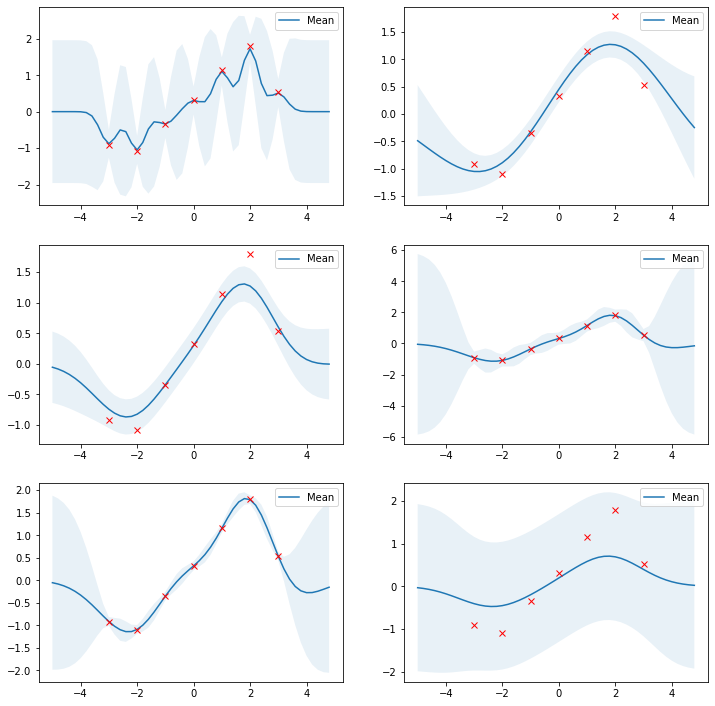

In [176]:
params = [
    (0.3, 1.0, 0.2),
    (3.0, 1.0, 0.2),
    (1.0, 0.3, 0.2),
    (1.0, 3.0, 0.2),
    (1.0, 1.0, 0.05),
    (1.0, 1.0, 1.5),
]

plt.figure(figsize=(12, 5))

for i, (l, sigma_f, sigma_y) in enumerate(params):
    mu_s, cov_s = posterior(X, X_train, Y_train, l=l, 
                            sigma_f=sigma_f, 
                            sigma_y=sigma_y)
    plt.subplot(3, 2, i + 1)
    plt.subplots_adjust(top=2)
    plt.title(f'l = {l}, sigma_f = {sigma_f}, sigma_y = {sigma_y}')
    plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)

Optimal values for these parameters can be estimated by maximizing the log marginal likelihood which is given by

$$\log p(y|X) = \log \mathcal{N}(y|0, K_y) = -\frac{1}{2}y^TK_y^{-1}y - \frac{1}{2}\log |k_y| - \frac{N}{2} \log(2\pi)$$

In the following we will minimize the negative log marginal likelihood w.r.t parameters $l$ and $\sigma_f$, $\sigma_y$ is set to the known noise level of the data. If the noise level is unknown, $\sigma_y$ can be estimated as well along with the other parameters.

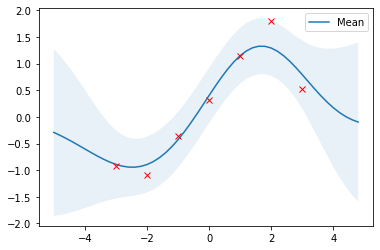

In [188]:
from numpy.linalg import cholesky, det, lstsq
from scipy.optimize import minimize

def nll_fn(X_train, Y_train, noise, naive=True):
    """
    Returns a function that computes the negative log marginal
    likelihood for training data X_train and Y_train and given
    noise level.
    
    Args:
        X_train: training locations (m x d)
        Y_train: training targets (m x 1)
        noise: knwon noise level of Y_train
        naive: if True use a naive implementation of equation above,
        if false use a numerically more stable implementation
        
    Returns:
        Minimization objective.
    """
    
    Y_train = Y_train.ravel()
    
    def nll_naive(theta):
        # Naive implementation of equation above. Works well
        # for simple examples but is numerically less stable 
        # compared to the implementation of nll_stable
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) \
                  + noise**2 * np.eye(len(X_train))
        return (0.5 * np.log(det(K))
                + 0.5 * Y_train.dot(inv(K).dot(Y_train))
                + 0.5 * len(X_train) * np.log(2*np.pi))
    
    def nll_stable(theta):
        # Numerically more stable implementation of the equation
        # above  as described in http://www.gaussianprocess.org/gpml/chapters/RW2.pdf, Section
        # 2.2, Algorithm 2.1.
        
        def ls(a, b):
            return lstsq(a, b, rcond=-1)[0]
        
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) \
            + noise **2 * np.eye(len(X_train))
        return (np.sum(np.log(np.diagonal(L)))
                + 0.5 * Y_train.dot(ls(L.T, ls(L, Y_train)))
                + 0.5 * len(X_train) * np.log(2*np.pi))
    
    if naive:
        return nll_naive
    else:
        return nll_stable
    
# Minimize the negative log-likelihood w.r.t parameters l and
# sigma_f. We should actually run the minimization several times
# with different initializations to avoid local minima but this is
# skipped here for simplicity
res = minimize(nll_fn(X_train, Y_train, noise), 
               [1,1],
               bounds = ((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

# Store the optimization results in global variables so that we can
# compare it later with the results from other implementations
l_opt, sigma_f_opt = res.x

# Compute the posterior mean and covariance with optimized kernel parameters
mu_s, cov_s = posterior(X, X_train, Y_train, l=l_opt, sigma_f=sigma_f_opt, sigma_y=noise)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)

With optimized kernel parameters, training data are reasonably covered by the 95% confidence interval and the mean of the posterior is a good approximation.

# Higher dimensions

The above implemenation can also be used for higher input data dimensions. Here, a GP is used to fit noisy samples from a sine wave originating at 0 and expanding in the x-y plane. The following plots show the noisy samples and the posterior mean before and after kernel parameter optimization.

In [189]:
def plot_gp_2D(gx, gy, mu, X_train, Y_train, title, i):
    ax = plt.gcf().add_subplot(1, 2, i, projection='3d')
    ax.plot_surface(gx, gy, mu.reshape(gx.shape), cmap=cm.coolwarm, linewidth=0, alpha=0.2, antialiased=False)
    ax.scatter(X_train[:,0], X_train[:,1], Y_train, c=Y_train, cmap=cm.coolwarm)
    ax.set_title(title)

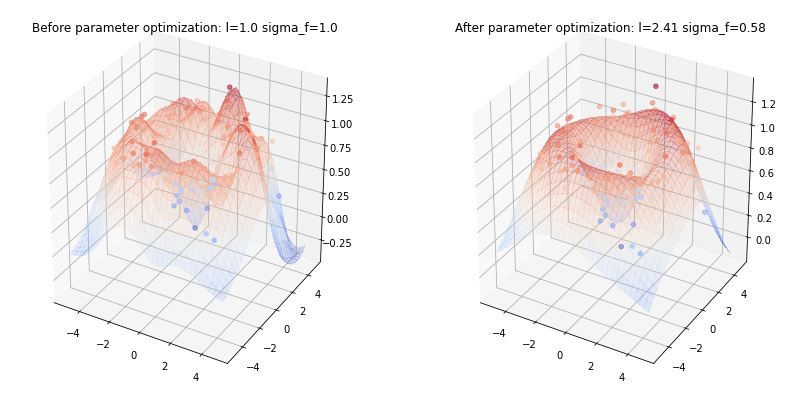

In [192]:
from matplotlib import cm
noise_2D = 0.1

rx, ry = np.arange(-5, 5, 0.3), np.arange(-5, 5, 0.3)
gx, gy = np.meshgrid(rx, rx)

X_2D = np.c_[gx.ravel(), gy.ravel()]

X_2D_train = np.random.uniform(-4, 4, (100, 2))
Y_2D_train = np.sin(0.5 * np.linalg.norm(X_2D_train, axis=1)) + \
             noise_2D * np.random.randn(len(X_2D_train))

plt.figure(figsize=(14,7))

mu_s, _ = posterior(X_2D, X_2D_train, Y_2D_train, sigma_y=noise_2D)
plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train, 
           f'Before parameter optimization: l={1.00} sigma_f={1.00}', 1)

res = minimize(nll_fn(X_2D_train, Y_2D_train, noise_2D), [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

mu_s, _ = posterior(X_2D, X_2D_train, Y_2D_train, *res.x, sigma_y=noise_2D)
plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train,
           f'After parameter optimization: l={res.x[0]:.2f} sigma_f={res.x[1]:.2f}', 2)